In [1]:
import numpy
import scipy
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap
import matplotlib.colors
nicebwr = matplotlib.colors.LinearSegmentedColormap.from_list("nicebwr",["#094da0","#FFFFFF","#ef1a2d"])
import scha

import importlib
importlib.reload(scha)

cos = numpy.cos; sin = numpy.sin

%matplotlib nbagg

### crear puntos

In [2]:
import fibonacci_sphere

In [3]:
def angulardist(theta1, phi1, theta2, phi2):
    return numpy.arccos(sin(theta1)*sin(theta2)*cos(phi1 - phi2)+cos(theta1)*cos(theta2))

In [4]:
theta_c, phi_c, theta_0 = numpy.deg2rad((90-45.0, 15.0, 20.0))
lat_c, lon_c = 90 - numpy.rad2deg(theta_c), numpy.rad2deg(phi_c)

In [5]:
thetav, phiv = fibonacci_sphere.grid(4000)
inside_cap_index = angulardist(thetav, phiv, theta_c, phi_c) < theta_0
thetav = thetav[inside_cap_index]
phiv = phiv[inside_cap_index]

<IPython.core.display.Javascript object>


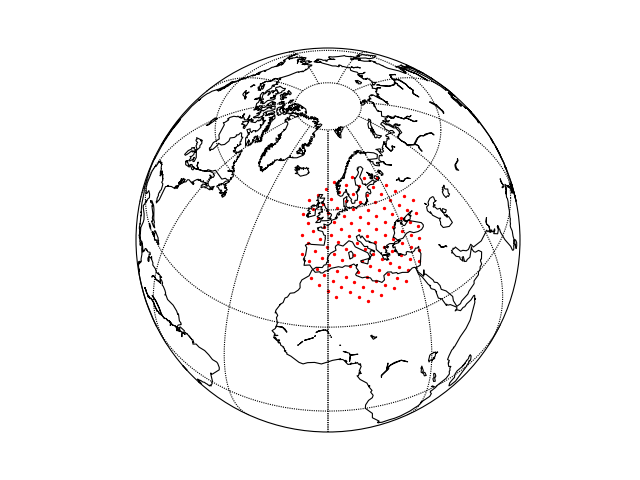

In [6]:
fig, ax = pyplot.subplots()

base = Basemap(projection="ortho", lat_0 = 45, lon_0 = 0, resolution="c")

base.drawmeridians(numpy.linspace(0, 360, 12), ax=ax)
base.drawparallels(numpy.linspace(-90, 90, 6), ax=ax)
base.drawcoastlines(ax=ax)

lat = 90 - numpy.rad2deg(thetav); lon = numpy.rad2deg(phiv)
base.scatter(lon, lat, s=4, latlon=True, ax=ax, color="red")

pyplot.show(fig)

### qué hora es

In [7]:
import datetime

In [8]:
date = datetime.datetime(2001, 1, 1)
ref = datetime.datetime(2000, 1, 1)
mjd = (date - ref).total_seconds()/(24*3600)

### exportar datos

In [10]:
lat = 90 - numpy.rad2deg(thetav)
lon = numpy.rad2deg(phiv)
r = numpy.zeros_like(lat)
times = numpy.ones_like(lat)*mjd

datos = numpy.stack((lat, lon, r, times))

In [72]:
numpy.savetxt("/home/josecper/Programs/data/scha/pruebas/input.dat", datos.T, fmt="%8.4f", delimiter="\t")

#### salida del modelo chaos

In [12]:
chaos_preds = numpy.loadtxt("/home/josecper/Programs/data/scha/pruebas/CHAOS_preds.dat",
                            comments="%")

Bz_chaos, Bx_chaos, By_chaos = -chaos_preds[:, 4], -chaos_preds[:, 5], chaos_preds[:, 6]
del chaos_preds

In [14]:
aind = numpy.argsort(thetav)
for th, bx, by, bz in zip(thetav[aind], Bx_chaos[aind], By_chaos[aind], Bz_chaos[aind]):
    print("{:8.4f}   {:+8.2f}   {:+8.2f}   {:+8.2f}".format(th, bx, by, bz))

  0.4651   +32293.54    +655.34   +24026.68
  0.4794   +31548.49    -470.78   +23719.70
  0.4880   +31838.01   +1199.61   +26682.79
  0.5017   +31218.27    +358.64   +26145.94
  0.5099   +31170.44   +1602.59   +29248.10
  0.5150   +30485.77   -1006.22   +25777.14
  0.5231   +30759.42    +941.77   +28509.85
  0.5359   +30171.72      -9.67   +27989.42
  0.5437   +30121.17   +1430.04   +30839.17
  0.5485   +29442.09   -1700.40   +27733.95
  0.5562   +29697.93    +646.69   +30120.03
  0.5637   +29497.90   +1759.03   +33124.82
  0.5684   +29122.55    -502.87   +29604.80
  0.5757   +29137.87   +1186.08   +32279.04
  0.5803   +28426.77   -2467.78   +29669.05
  0.5876   +28668.88    +298.41   +31532.00
  0.5947   +28473.66   +1627.47   +34286.92
  0.5992   +28161.32   -1172.08   +31108.95
  0.6062   +28112.05    +882.20   +33511.20
  0.6132   +27805.47   +1853.32   +36303.01
  0.6176   +27739.25    -132.65   +32779.26
  0.6244   +27478.45   +1393.21   +35372.81
  0.6287   +27200.17   -1888.85 

### vamos a rotar

In [15]:
rot_mat = scha.rotation_matrix(theta_c, phi_c, invert=True)
r, theta_r, phi_r = scha.rotate_coords(1.0, thetav, phiv, rot_mat)

Bx_r = numpy.empty_like(Bx_chaos); By_r = numpy.empty_like(By_chaos); Bz_r = numpy.empty_like(Bz_chaos)

for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_chaos,By_chaos,Bz_chaos,thetav,phiv,theta_r)):
    #x_r[i], y_r[i], z_r[i] = scha.rotate_vector(xx, yy, zz, th_p, ph_p, th_i, phi_i, th_ri)
    Bx_r[i], By_r[i], Bz_r[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                   th_i, phi_i, th_ri)

#### hemos rotado

<IPython.core.display.Javascript object>


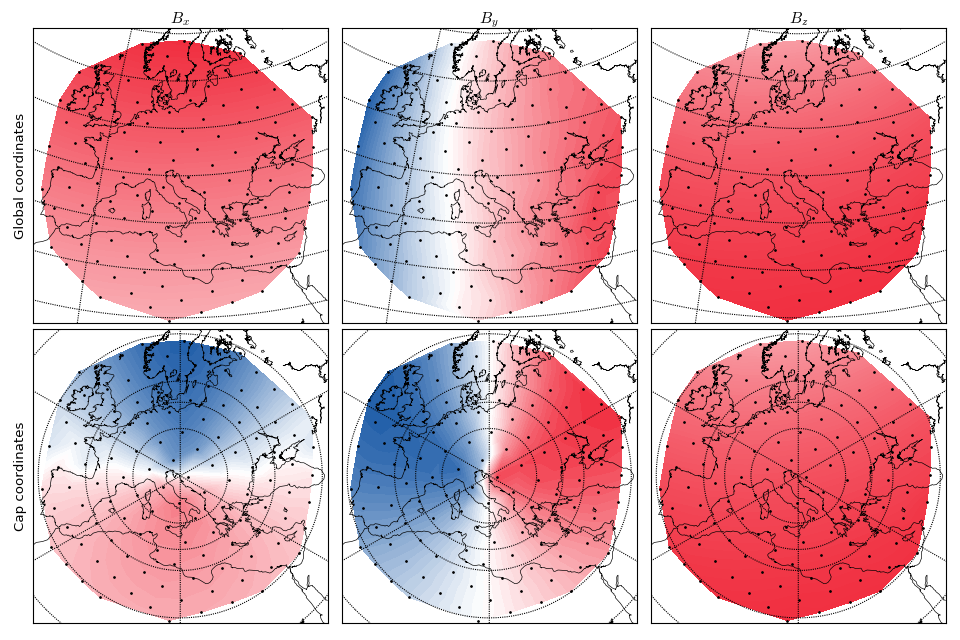

In [16]:
fig, axes = pyplot.subplots(2, 3, figsize=(12,8))

base = Basemap(projection="npaeqd", lon_0 = 0, boundinglat=90-20)
base2 = Basemap(projection="aeqd", lon_0 = lon_c, lat_0=lat_c, lat_ts=lat_c,
                width=base.xmax, height=base.ymax, resolution="l")
#scha.polar_contour(Bx_r, theta_r, phi_r, theta_0, ax=ax, resolution=200, base=base)
scha.polar_tricontour(Bx_chaos, theta_r, phi_r, theta_0, ax=axes[0][0], base=base, cmap=nicebwr)
scha.polar_tricontour(By_chaos, theta_r, phi_r, theta_0, ax=axes[0][1], base=base, cmap=nicebwr)
scha.polar_tricontour(Bz_chaos, theta_r, phi_r, theta_0, ax=axes[0][2], base=base, cmap=nicebwr)

axes[0][0].set_title("$B_{x}$")
axes[0][1].set_title("$B_{y}$")
axes[0][2].set_title("$B_{z}$")

scha.polar_tricontour(Bx_r, theta_r, phi_r, theta_0, ax=axes[1][0], base=base, cmap=nicebwr)
scha.polar_tricontour(By_r, theta_r, phi_r, theta_0, ax=axes[1][1], base=base, cmap=nicebwr)
scha.polar_tricontour(Bz_r, theta_r, phi_r, theta_0, ax=axes[1][2], base=base, cmap=nicebwr)

axes[0][0].set_ylabel("Global coordinates")
axes[1][0].set_ylabel("Cap coordinates")

for ax in axes[0]:
    base2.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base2.drawparallels(numpy.linspace(0, 90, 15), ax=ax, color="black")
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)
    
for ax in axes[1]:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(0, 90, 15), ax=ax, color="black")
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)

fig.tight_layout()
pyplot.show(fig)

### inversión XYZ

#### primero hallamos las raíces de los polinomios

In [62]:
ms = numpy.arange(0, 9);
roots = scha.degree(ms, theta0 = numpy.deg2rad(50), max_k = 8)
k, m, n = scha.join_roots(roots)

#### invertir la cosa

In [18]:
g = scha.invert_xyz(theta_r, phi_r, Bx_r, By_r, Bz_r, (k, m, n))

In [19]:
Bx_inv, By_inv, Bz_inv = scha.xyzfield(k, m, n, g, theta_r, phi_r)

<IPython.core.display.Javascript object>


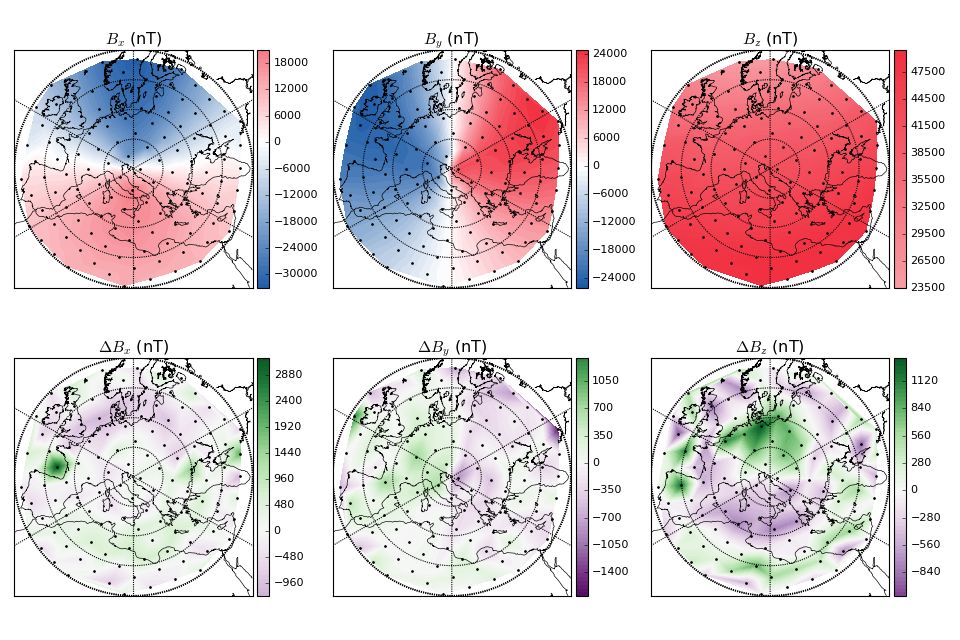

In [20]:
fig, (axes, raxes) = pyplot.subplots(2, 3, figsize=(12,8))

base = Basemap(projection="npstere", lon_0 = 0, boundinglat=90-20)
base2 = Basemap(projection="stere", lon_0 = lon_c, lat_0=lat_c, lat_ts=lat_c,
                width=base.xmax, height=base.ymax, resolution="l")
#scha.polar_contour(Bx_r, theta_r, phi_r, theta_0, ax=ax, resolution=200, base=base)

for Bi, ax in zip((Bx_inv, By_inv, Bz_inv), axes):
    cbar=base.colorbar(scha.polar_tricontour(Bi, theta_r, phi_r, theta_0, ax=ax, base=base, cmap=nicebwr),
                       location="right", ax=ax)
    cbar.ax.tick_params(labelsize=10)

for ax in axes:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(90-20, 90, 5), ax=ax, color="black")
    base.drawparallels([90-numpy.rad2deg(theta_0)],
                       ax=ax, color="black", linewidth=1.8, dashes=[1,1], latmax=90)
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)
    
axes[0].set_title("$B_{x}$ (nT)"); axes[1].set_title("$B_{y}$ (nT)"); axes[2].set_title("$B_{z}$ (nT)")

for Bi, Bri, ax in zip((Bx_inv, By_inv, Bz_inv), (Bx_r, By_r, Bz_r), raxes):
    cbar=base.colorbar(scha.polar_tricontour(Bi-Bri, theta_r, phi_r, theta_0, ax=ax, base=base, cmap="PRGn"),
                  location="right", ax=ax)
    cbar.ax.tick_params(labelsize=10)

for ax in raxes:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(90-20, 90, 5), ax=ax, color="black")
    base.drawparallels([90-numpy.rad2deg(theta_0)],
                       ax=ax, color="black", linewidth=1.8, dashes=[1,1], latmax=90)
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)
    
raxes[0].set_title(r"$\Delta B_{x}$ (nT)")
raxes[1].set_title(r"$\Delta B_{y}$ (nT)")
raxes[2].set_title(r"$\Delta B_{z}$ (nT)")
    
fig.tight_layout()

In [63]:
print("{:>10}{:>10}        {:>12}        {:>11}        {:>11}".format("k", "m", "n(k,m)", "g(k,m)", "K(n,m)"))
print("----------------------------------------------------------------------------------------")

for ki, mi, ni, gi, si in zip(k, m, n, g, scha.schmidt_real(m, n, grid=False)):
    print("{:>10}{:>10}        {:12.7f}        {:+11.6e}        {:+11.6e}".format(ki, mi, ni, gi, si))

         k         m              n(k,m)             g(k,m)             K(n,m)
----------------------------------------------------------------------------------------
         0         0           0.0000000        -6.498256e+04        +1.000000e+00
         1         0           2.2400370        +3.175804e+04        +1.000000e+00
         1         1           1.7833752        +6.637712e+04        -6.347574e-01
         1        -1           1.7833752        +2.487572e+03        -6.347574e-01
         2         0           3.9207043        -6.655297e+04        +1.000000e+00
         2         1           3.9207043        -1.887813e+05        -3.219729e-01
         2        -1           3.9207043        -9.615673e+03        -3.219729e-01
         2         2           3.2739690        -2.888698e+04        +1.091694e-01
         2        -2           3.2739690        +1.492353e+03        +1.091694e-01
         3         0           5.8186186        +1.151569e+05        +1.000000e+00
  

### inversión DIF

#### primero con los vectores ya transformados

In [22]:
import xyzfield

In [23]:
D_r, I_r, F_r, H_r = xyzfield.xyz2difh(Bx_r, By_r, Bz_r)

<IPython.core.display.Javascript object>


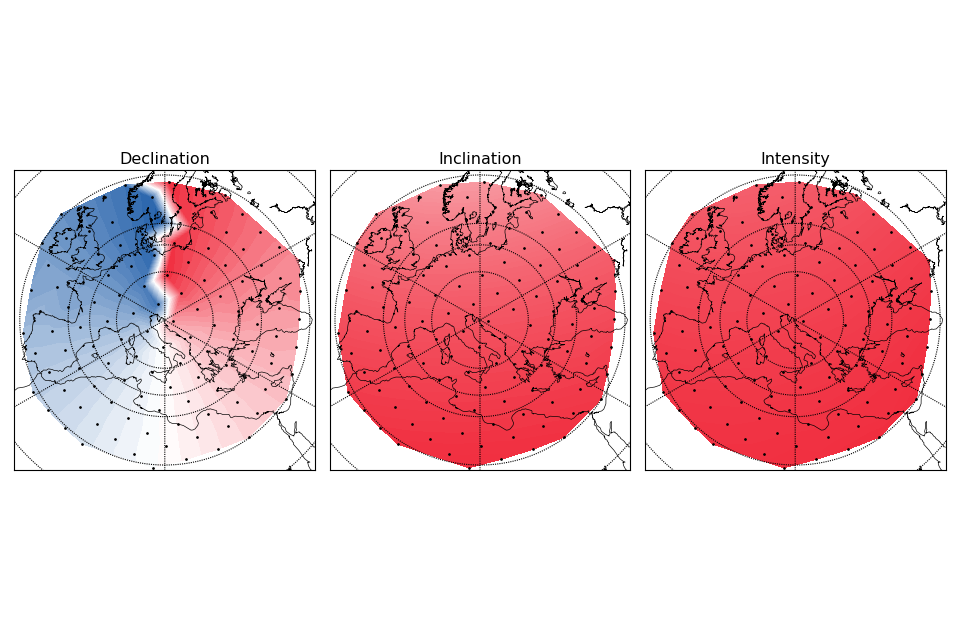

In [24]:
fig, axes = pyplot.subplots(1, 3, figsize=(12,8))

base = Basemap(projection="npaeqd", lon_0 = 0, boundinglat=90-20)
base2 = Basemap(projection="aeqd", lon_0 = lon_c, lat_0=lat_c, lat_ts=lat_c,
                width=base.xmax, height=base.ymax, resolution="l")
#scha.polar_contour(Bx_r, theta_r, phi_r, theta_0, ax=ax, resolution=200, base=base)
scha.polar_tricontour(D_r, theta_r, phi_r, theta_0, ax=axes[0], base=base, cmap=nicebwr)
scha.polar_tricontour(I_r, theta_r, phi_r, theta_0, ax=axes[1], base=base, cmap=nicebwr)
scha.polar_tricontour(F_r, theta_r, phi_r, theta_0, ax=axes[2], base=base, cmap=nicebwr)

for ax in axes:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(0, 90, 15), ax=ax, color="black")
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)

axes[0].set_title("Declination")
axes[1].set_title("Inclination")
axes[2].set_title("Intensity")

fig.tight_layout()
pyplot.show(fig)

#### invertimos estos datos

In [25]:
ms = numpy.arange(0, 18);
roots = scha.degree(ms, theta0 = theta_0, max_k = 17)
k, m, n = scha.join_roots(roots)

In [58]:
importlib.reload(scha)
gp = scha.invert_dif(theta_r, phi_r, D_r, I_r, F_r, (k, m, n), g0=None, steps=15)

0.676983089139

In [59]:
Bx_invdif, By_invdif, Bz_invdif = scha.xyzfield(k, m, n, gp, theta_r, phi_r)

<IPython.core.display.Javascript object>


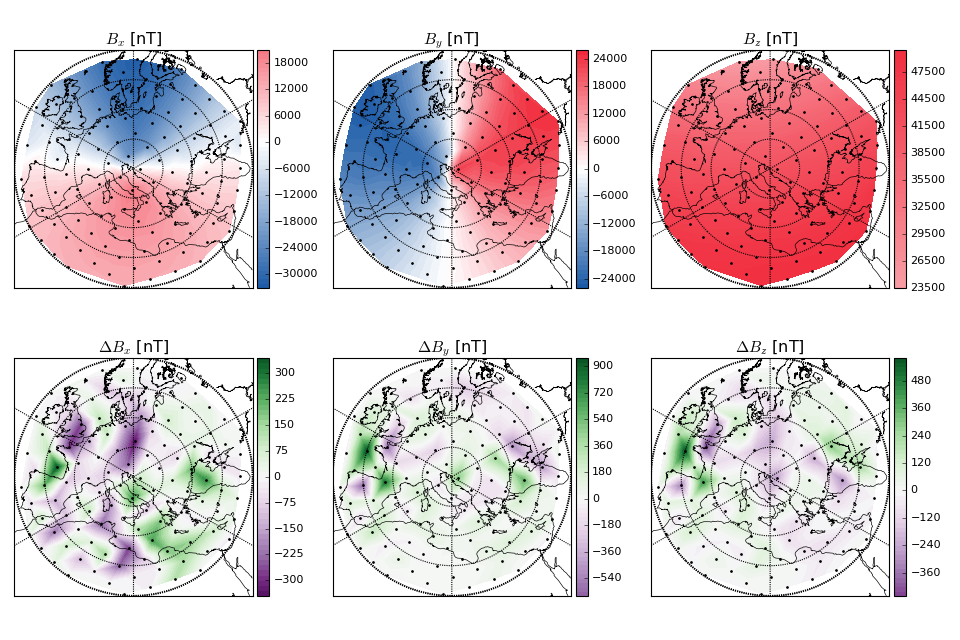

In [60]:
fig, (axes, raxes) = pyplot.subplots(2, 3, figsize=(12,8))

base = Basemap(projection="npstere", lon_0 = 0, boundinglat=90-20)
base2 = Basemap(projection="stere", lon_0 = lon_c, lat_0=lat_c, lat_ts=lat_c,
                width=base.xmax, height=base.ymax, resolution="l")
#scha.polar_contour(Bx_r, theta_r, phi_r, theta_0, ax=ax, resolution=200, base=base)

for Bi, ax in zip((Bx_invdif, By_invdif, Bz_invdif), axes):
    cbar=base.colorbar(scha.polar_tricontour(Bi, theta_r, phi_r, theta_0, ax=ax, base=base, cmap=nicebwr),
                       location="right", ax=ax)
    cbar.ax.tick_params(labelsize=10)

for ax in axes:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(90-20, 90, 5), ax=ax, color="black")
    base.drawparallels([90-numpy.rad2deg(theta_0)],
                       ax=ax, color="black", linewidth=1.8, dashes=[1,1], latmax=90)
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)
    
axes[0].set_title("$B_{x}$ [nT]"); axes[1].set_title("$B_{y}$ [nT]"); axes[2].set_title("$B_{z}$ [nT]")

for Bi, Bri, ax in zip((Bx_invdif, By_invdif, Bz_invdif), (Bx_r, By_r, Bz_r), raxes):
    cbar=base.colorbar(scha.polar_tricontour(Bi-Bri, theta_r, phi_r, theta_0, ax=ax, base=base, cmap="PRGn"),
                  location="right", ax=ax)
    cbar.ax.tick_params(labelsize=10)

for ax in raxes:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(90-20, 90, 5), ax=ax, color="black")
    base.drawparallels([90-numpy.rad2deg(theta_0)],
                       ax=ax, color="black", linewidth=1.8, dashes=[1,1], latmax=90)
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)
    
raxes[0].set_title(r"$\Delta B_{x}$ [nT]")
raxes[1].set_title(r"$\Delta B_{y}$ [nT]")
raxes[2].set_title(r"$\Delta B_{z}$ [nT]")
    
fig.tight_layout()

In [55]:
D_inv, I_inv, F_inv, H_inv = xyzfield.xyz2difh(Bx_invdif, By_invdif, Bz_invdif)

<IPython.core.display.Javascript object>


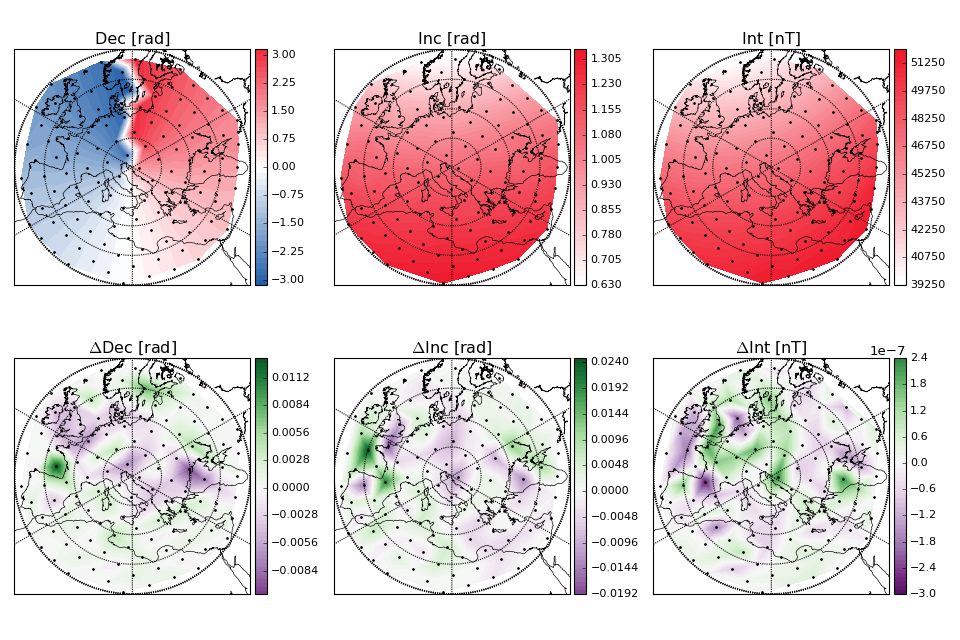

In [56]:
fig, (axes, raxes) = pyplot.subplots(2, 3, figsize=(12,8))

base = Basemap(projection="npstere", lon_0 = 0, boundinglat=90-20)
base2 = Basemap(projection="stere", lon_0 = lon_c, lat_0=lat_c, lat_ts=lat_c,
                width=base.xmax, height=base.ymax, resolution="l")
#scha.polar_contour(Bx_r, theta_r, phi_r, theta_0, ax=ax, resolution=200, base=base)

cbar=base.colorbar(scha.polar_tricontour(D_inv, theta_r, phi_r, theta_0, ax=axes[0], base=base, cmap=nicebwr),
                   location="right", ax=axes[0])
cbar.ax.tick_params(labelsize=10)

cbar=base.colorbar(scha.polar_tricontour(I_inv, theta_r, phi_r, theta_0, ax=axes[1], base=base, cmap=nicebwr,
                                         scale="positive"),
                   location="right", ax=axes[1])
cbar.ax.tick_params(labelsize=10)

cbar=base.colorbar(scha.polar_tricontour(F_inv, theta_r, phi_r, theta_0, ax=axes[2], base=base, cmap=nicebwr,
                                         scale="positive"),
                   location="right", ax=axes[2])
cbar.ax.tick_params(labelsize=10)

for ax in axes:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(90-20, 90, 5), ax=ax, color="black")
    base.drawparallels([90-numpy.rad2deg(theta_0)],
                       ax=ax, color="black", linewidth=1.8, dashes=[1,1], latmax=90)
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)
    
axes[0].set_title("Dec [rad]"); axes[1].set_title("Inc [rad]"); axes[2].set_title("Int [nT]")

for Bi, Bri, ax in zip((D_inv, I_inv, F_inv), (D_r, I_r, F_r), raxes):
    cbar=base.colorbar(scha.polar_tricontour(Bi-Bri, theta_r, phi_r, theta_0, ax=ax, base=base, cmap="PRGn"),
                  location="right", ax=ax)
    cbar.ax.tick_params(labelsize=10)

for ax in raxes:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(90-20, 90, 5), ax=ax, color="black")
    base.drawparallels([90-numpy.rad2deg(theta_0)],
                       ax=ax, color="black", linewidth=1.8, dashes=[1,1], latmax=90)
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)
    
raxes[0].set_title(r"$\Delta$Dec [rad]")
raxes[1].set_title(r"$\Delta$Inc [rad]")
raxes[2].set_title(r"$\Delta$Int [nT]")
    
fig.tight_layout()

In [42]:
D_r

array([-1.87319567, -1.7864871 , -2.10498913, -1.29813974, -1.78062792,
       -1.45087535, -2.03255981, -1.1681377 , -1.66964741, -0.95708199,
       -2.29107241, -1.30859578, -1.94608117, -1.0202043 , -1.73081982,
       -0.81618156, -2.24019165, -1.13908722, -1.83362135, -0.85874145,
       -2.49848082, -1.34427497, -0.67286781, -2.1798412 , -0.94559717,
       -1.67464415, -0.68623985, -2.48332392, -1.10963974, -0.52153186,
       -2.09944599, -0.7246394 , -2.71028275, -1.43342066, -0.50660182,
       -2.47798416, -0.82782971, -1.96627208, -0.50479311, -2.73807811,
       -1.0689965 , -0.33916416, -2.48590996, -0.52504798, -1.6880879 ,
       -0.29890108, -2.79905907, -0.60285635, -0.16899706, -2.5199499 ,
       -0.25241719, -2.97134168, -0.94908548, -0.10992898, -2.91538874,
       -0.18257169, -0.02874215, -2.67832833, -0.01842392, -3.08229623,
       -0.01662962,  0.04192692,  3.1229389 ,  0.11488541,  3.11807898,
        1.46935908,  0.15559197,  3.01899622,  0.3686778 ,  0.18

In [43]:
D_orig=xyzfield.xyz2difh(Bx_chaos, By_chaos, Bz_chaos)[0]

In [51]:
D_rr=scha.rotate_declination(D_orig, theta_c, phi_c, thetav, phiv, theta_r)